In [1]:
%autosave 0
from __future__ import absolute_import, division, print_function
%pylab inline
%load_ext autoreload
%autoreload 2
import os
import time
import numpy as np

import numpy
import tensorflow as tf

from tensorflow import app
from tensorflow import flags
from tensorflow import gfile
from tensorflow import logging

import eval_util
import losses
import readers
import utils
import pickle

%matplotlib inline
import matplotlib.pyplot as plt

Autosave disabled
Populating the interactive namespace from numpy and matplotlib


In [2]:
pre = []

def inference(reader, train_dir, data_pattern, batch_size):
  with tf.Session() as sess:
    latest_checkpoint = tf.train.latest_checkpoint(train_dir)
    if latest_checkpoint is None:
      raise Exception("unable to find a checkpoint at location: %s" % train_dir)
    else:
      meta_graph_location = latest_checkpoint + ".meta"
      logging.info("loading meta-graph: " + meta_graph_location)
    saver = tf.train.import_meta_graph(meta_graph_location, clear_devices=True)
    logging.info("restoring variables from " + latest_checkpoint)
    saver.restore(sess, latest_checkpoint)
    
    input_tensor = tf.get_collection("input_batch")[0]
    seq_len_tensor = tf.get_collection("seq_len")[0]
    labels_tensor = tf.get_collection("labels")[0]
    predictions_tensor = tf.get_collection("predictions")[0]
    train_batch_tensor = tf.get_collection("train_batch")[0]
    decodedPrediction = []
    for i in range(2):
            decodedPrediction.append(tf.get_collection("decodedPrediction{}".format(i))[0])
    # Workaround for num_epochs issue.
    def set_up_init_ops(variables):
      init_op_list = []
      for variable in list(variables):
        if "train_input" in variable.name:
          init_op_list.append(tf.assign(variable, 1))
          variables.remove(variable)
      init_op_list.append(tf.variables_initializer(variables))
      return init_op_list   

    sess.run(set_up_init_ops(tf.get_collection_ref(tf.GraphKeys.LOCAL_VARIABLES)))

    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    num_examples_processed = 0
    start_time = time.time()
    
    #vocabulary = eval_util.read_vocab(29)
    #vocabulary = sorted(vocabulary, key=lambda word: len(word))

    try:
      while not coord.should_stop() :
          
          
          labels, imgs, predictions_val, soft = sess.run([labels_tensor,input_tensor,
                                      decodedPrediction,predictions_tensor], 
                                     feed_dict={#input_tensor: np.array(xx,dtype=np.float32).reshape((20,-1))-1.0,
                                                #np.ones((50,28*12*36*18)),
                                               # seq_len_tensor:np.array(ll),#np.ones((50,1))*10,
                                               train_batch_tensor: False})
          #print(predictions_val[0])
          pre.append([predictions_val,labels])
          eval_util.show_prediction(predictions_val,labels,None, 30)
          return imgs, soft

    except tf.errors.OutOfRangeError:
        logging.info('Done with inference. The output file was written to ')
    finally:
        coord.request_stop()

    coord.join(threads)
    sess.close()


imgs, soft = inference(None, 'separable_lstm', 'no',20)



INFO:tensorflow:loading meta-graph: separable_lstm/model.ckpt-6000.meta
INFO:tensorflow:restoring variables from separable_lstm/model.ckpt-6000
('corr:', ['t', 'h', 'e'])
('pred:', ['t', 'h', 'e'])
('pred:', ['t', 'o', 'h', 'e'])
----------
('corr:', ['w', 'h', 'o'])
('pred:', ['w', 'h', 'o'])
('pred:', ['u', 'h', 'o'])
----------
('corr:', ['m', 'e', 't', 'h', 'o', 'd'])
('pred:', ['m', 'e', 't', 'h', 'o', 'd'])
('pred:', ['m', 'e', 't', 'h', 'a', 'd'])
----------
('corr:', ['m', 'a', 'n', 'y'])
('pred:', ['m', 'a', 'n', 'y'])
('pred:', ['m', 'n', 'a', 'n', 'y'])
----------
('corr:', ['a', 's', 'k', 'e', 'd', ' ', 'm', 'e'])
('pred:', ['a', 'o', 'h', 'e', 'd', ' ', 'm', 'e'])
('pred:', ['a', 'h', 'e', 'd', ' ', 'm', 'e'])
----------
('corr:', ['t', 'h', 'a', 't'])
('pred:', ['t', 'o', 't'])
('pred:', ['t', 'h', 'o', 't'])
----------
('corr:', ['n', 'e', 'w', ' ', 'c', 'h', 'u', 'r', 'c', 'h'])
('pred:', ['n', 'e', 'w', ' ', 'i', 'h', 'u', 'v', 'i', 'h'])
('pred:', ['n', 'e', 'w', ' ',

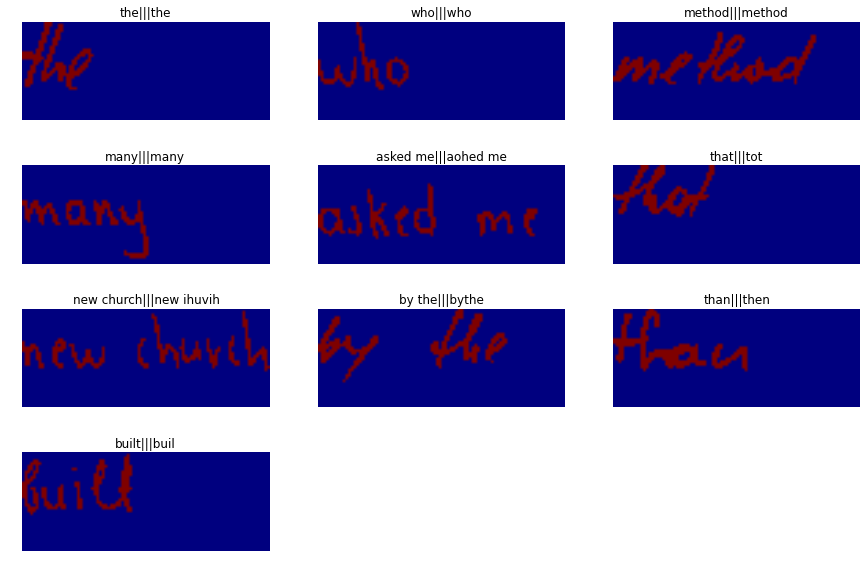

In [5]:
voc = eval_util.get_characters()
plt.figure(figsize=(15,15))
for ii in range(0,10):
    plt.subplot(6,3,1+ii)
    plt.title(''+''.join([eval_util.getIndex(j,voc) for j in pre[0][1][ii] if j])+'|||'\
             +''.join([eval_util.getIndex(j,voc) for j in pre[0][0][0][ii] if j]))
    plt.imshow(imgs[ii].reshape((36,90))),plt.axis('off')#,plt.colorbar()

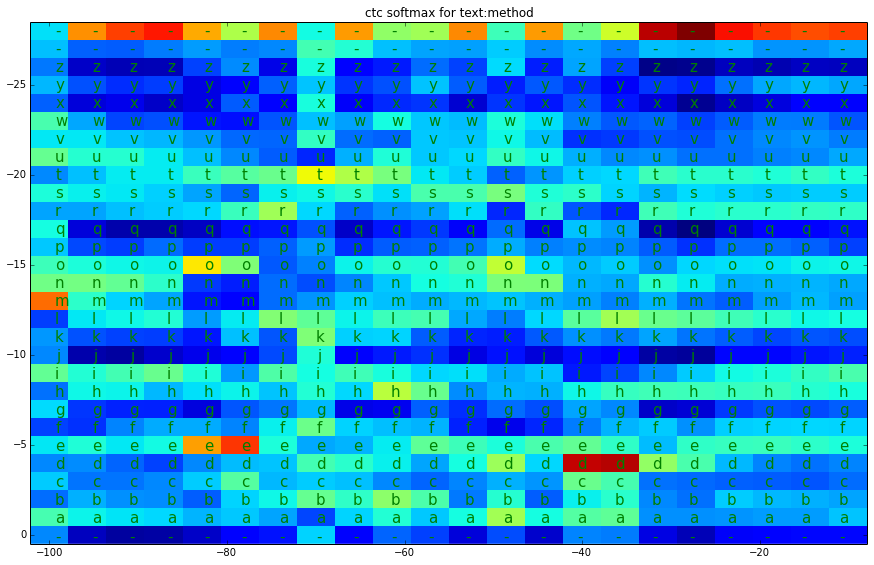

In [7]:
def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

id_image = 2

x = np.linspace(-100, -10, 22)
y = np.array([-i for i in range(29)])
data = np.random.randn(y.size,x.size)

fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('ctc softmax for text:'+''.join([eval_util.getIndex(j,voc) for j in pre[0][1][id_image] if j]))
for j in range(22):
    for i in range(29):
        ax.text(0.03+0.0446*j, 0.0001+0.0346*i, chr(ord('a')+i-1) if i>0 and i<27 else '-',
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes,
            color='green', fontsize=15)
#ax.plot([2], [1], 'o')
ax.imshow(soft[:,id_image,:].transpose((1,0)), aspect='auto', interpolation='none',
           extent=extents(x) + extents(y), origin='lower')#,plt.colorbar()
#plt.colorbar()
#ax.axis([0, 10, 0, 10])

plt.show()